In [37]:
import os
import pandas as pd
from llama_index.core import Document, VectorStoreIndex, StorageContext, KnowledgeGraphIndex
from llama_index.core.graph_stores import SimpleGraphStore
from llama_index.llms.anthropic import Anthropic
import networkx as nx
import matplotlib.pyplot as plt
from torch.cuda import graph

In [38]:
base_path = "veri/42bin_haber/news"
rows = []

try:
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            for file_name in os.listdir(category_path):
                if file_name.endswith(".txt"):
                    file_path = os.path.join(category_path, file_name)
                    try:
                        with open(file_path, "r", encoding="utf-8") as f:
                            text = f.read().strip()
                            if len(text) > 30:
                                rows.append({"kategori": category, "metin": text})
                    except Exception as e:
                        print(f"Hata - Dosya okunamadı: {file_path} - {e}")
except Exception as e:
    print(f"Hata - Veri yolu bulunamadı: {base_path} - {e}")

df = pd.DataFrame(rows)
print(f"✓ Yüklenen haber sayısı: {len(df)}")
print(f"✓ Kategoriler: {df['kategori'].unique()}")
print(f"\nİlk haberler:\n{df.head()}\n")


✓ Yüklenen haber sayısı: 41988
✓ Kategoriler: ['dunya' 'ekonomi' 'genel' 'guncel' 'kultur-sanat' 'magazin' 'planet'
 'saglik' 'siyaset' 'spor' 'teknoloji' 'turkiye' 'yasam']

İlk haberler:
  kategori                                              metin
0    dunya  'Ortak vizyonumuz var'\nDışişleri Bakanı Davut...
1    dunya  İsrail'den Gazze Şeridi'ne hava saldırısı\nİsr...
2    dunya  Cenaze için geniş güvenlik önlemleri alındı\nL...
3    dunya  Gözaltındaki sendikacılar serbest\nKKTC'de Sen...
4    dunya  Bisikletle Asya'da 3 bin kilometre yol katetti...



In [39]:
documents = [
    Document(text=row["metin"], metadata={"kategori": row["kategori"]})
    for _, row in df.iterrows()
]
print(f" Toplam belge sayısı: {len(documents)}\n")

 Toplam belge sayısı: 41988



In [40]:
ANTHROPIC_API_KEY =""

In [15]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\samet\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\samet\AppData\Local\llama_index\llama_index\Cache\models--BAAI--bge-small-en-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [24]:
try:
    llm = Anthropic(model="claude-sonnet-4-5-20250929",api_key=ANTHROPIC_API_KEY)

    graph_store = SimpleGraphStore()
    storage_context = StorageContext.from_defaults(graph_store=graph_store)

    print("Bilgi Grafı oluşturuluyor... (Bu biraz zaman alabilir)\n")

    kg_index = KnowledgeGraphIndex.from_documents(
        documents[:50],
        storage_context=storage_context,
        llm=llm,
        max_triplets_per_chunk=1,
        embed_model=embed_model,
        show_progress=True
    )

    print(f"\n Bilgi Grafı başarıyla oluşturuldu!")

except Exception as e:
    print(f" Graph RAG hatası: {e}")

Bilgi Grafı oluşturuluyor... (Bu biraz zaman alabilir)



Parsing nodes:   0%|          | 0/50 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/60 [00:00<?, ?it/s]


✓ Bilgi Grafı başarıyla oluşturuldu!


In [27]:
query_engine = kg_index.as_query_engine(llm=llm)

sorgular = [
        "Dışişleri Bakanı Davutoğlu Yunanistan ile Türkiye hakkında ne söyledi?",
        "Borsa İstanbul hakkında neler yazıldı?",
        "Faiz kararının etkileri nelerdir?"
    ]

print("\n" + "="*60)
print("SORGU YANITLERI")
print("="*60 + "\n")

for sorgu in sorgular:
    print(f" Sorgu: {sorgu}")
    try:
        yanit = query_engine.query(sorgu)
        print(f" Yanıt: {yanit}\n")
    except Exception as e:
        print(f" Sorgu hatası: {e}\n")


SORGU YANITLERI

 Sorgu: Dışişleri Bakanı Davutoğlu Yunanistan ile Türkiye hakkında ne söyledi?
 Yanıt: Dışişleri Bakanı Davutoğlu, Yunanistan ile Türkiye arasındaki farklılıkların ortak vizyon ile çözülebileceğini söyledi. İki ülke arasında görüş ayrılıkları ve farklı yaklaşımlar olabileceğini belirten Davutoğlu, aynı vizyonun paylaşılmasıyla aradaki sorunların ve problemlerin daha rahat çözülebileceğini ifade etti. Ayrıca, Yunan mevkidaşı ile yaptığı görüşmelerden elde ettiği sonucun da bu yönde olduğunu vurguladı. Davutoğlu, birçok alanda ortak mutabakatların ilk tohumlarının atıldığını ve Ocak ayında her iki başbakanın eşbaşkanlığında Türkiye'de bir toplantı gerçekleşeceğini açıkladı.

 Sorgu: Borsa İstanbul hakkında neler yazıldı?
 Yanıt: Verilen bağlam bilgisinde Borsa İstanbul hakkında herhangi bir bilgi bulunmamaktadır. Sağlanan içerikte bu konuyla ilgili bir yazı veya bilgi yer almamaktadır.

 Sorgu: Faiz kararının etkileri nelerdir?
 Yanıt: Üzgünüm, verilen bağlam bilgisinde

Bilgi Grafı görselleştiriliyor...

✓ Bulunan edges: 70

✓ Grafik 'bilgi_grafi.png' olarak kaydedildi!


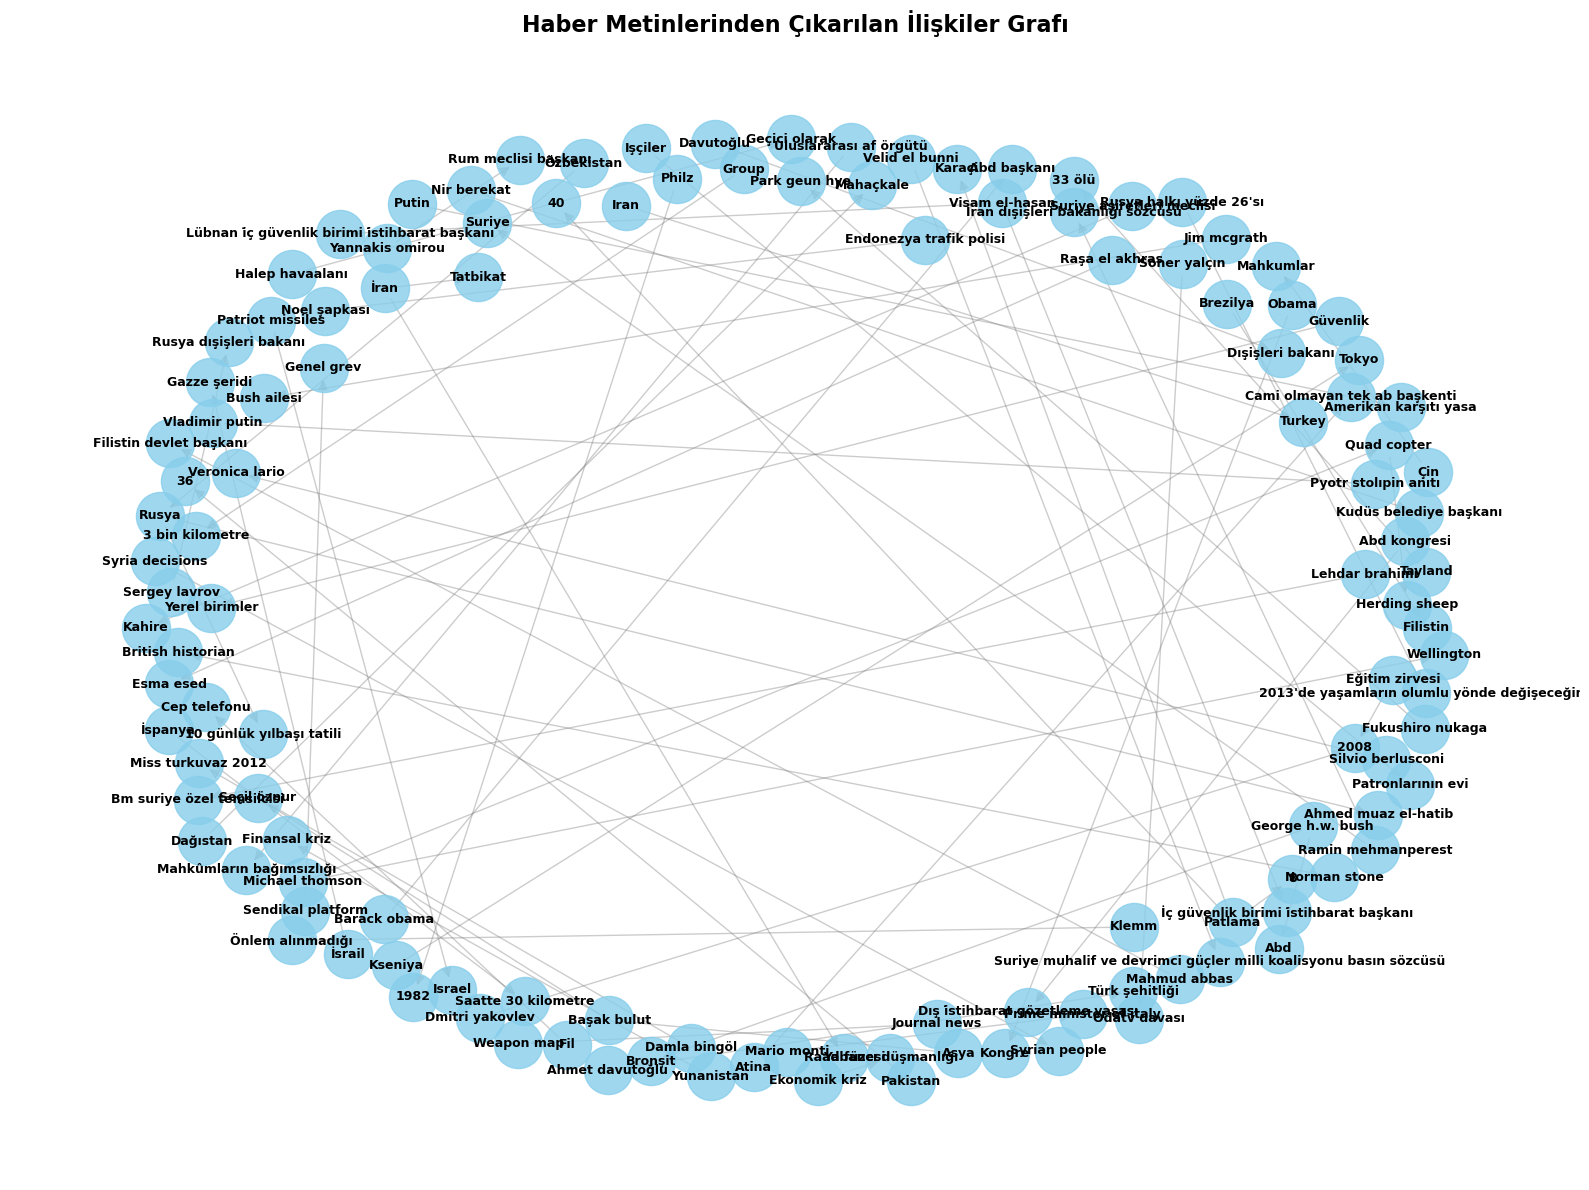

In [36]:
try:
    print("Bilgi Grafı görselleştiriliyor...\n")

    graph_store = kg_index.graph_store
    graph_data = graph_store._data
    graph_dict = graph_data.graph_dict

    # Edges çıkar
    edges = []

    for node, data in graph_dict.items():
        if isinstance(data, list):
            for item in data:
                if isinstance(item, list) and len(item) >= 2:
                    rel_type = item[0]
                    target = item[1]
                    edges.append((node, target))
                elif isinstance(item, tuple) and len(item) >= 2:
                    edges.append((node, item[1]))

    print(f" Bulunan edges: {len(edges)}\n")

    if edges and len(edges) > 10:
        G = nx.DiGraph()
        G.add_edges_from(edges[:150])

        plt.figure(figsize=(16, 12))
        pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1200, alpha=0.8)
        nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, alpha=0.4, arrowsize=15)
        nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

        plt.title("Haber Metinlerinden Çıkarılan İlişkiler Grafı", fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('bilgi_grafi.png', dpi=300, bbox_inches='tight')
        print(" Grafik 'bilgi_grafi.png' olarak kaydedildi!")
        plt.show()
    else:
        print(f" Yeterli veri yok (sadece {len(edges)} edge)")

except Exception as e:
    print(f"Hata: {e}")
    import traceback
    traceback.print_exc()